In [1]:
import sqlite3
import feedparser
import re
from bs4 import BeautifulSoup
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
from corextopic import corextopic as ct
import umap, umap.plot
import requests
import pandas as pd


count = 0

# list of feed urls loaded from the db
feed_url_list = []

# dict of feeds
# urls are keys the values are dicts containing
# features, title and description for that feed
feeds = dict()

# normalizes a string 
# - remove HTML tags (using BeautifulSoup)
# - convert to lower case
# - remove numbers
# - remove symbols
# - remove stop words (using NLTK)
def normalize(text):

    # remove HTML tags
    text = BeautifulSoup(text, 'html.parser').get_text()

    # convert to lower case
    text = text.lower()

    # remove numbers
    text = re.sub(r'\d+', '', text)

    # remove symbols
    text = text.replace('\n', ' ')
    text = re.sub(r'[^A-Za-z ]+', '', text)
    text = re.sub(r' +', ' ', text)

    # remove stop words
    tokenized = word_tokenize(text)
    text = ' '.join([word for word in tokenized if not word in stopwords.words('english')])

    return text

# load feeds urls of feeds that do not have features yet
def loadFeedUrls(no_feeds):

    # clear feed urls list and feeds dict
    feed_url_list.clear()
    feeds.clear()

    global count
    count = 0

    print('Loading feed urls...')

    # connect to the db
    conn = sqlite3.connect('feeds_dev.db')
    c = conn.cursor()

    # select urls 
    # add limit 100 during development
    c.execute('SELECT url FROM feeds WHERE _id > (SELECT _id FROM feeds WHERE text IS NOT NULL AND title IS NOT NULL AND description IS NOT NULL ORDER BY _id DESC LIMIT 1) LIMIT ?;', (no_feeds,))    
    for entry in c.fetchall():
        feed_url_list.append(entry[0])

    print('Loaded feeds\n')

# analyze a feed and generate its initial body of text
def parseFeed(url):

    global count
    count += 1
    print('Generating features for ', url, ' ', str(count))

    # return if the feed can not be parsed
    try:

        # get the rss feed content from the url
        headers = {'User-Agent': 'Mozilla/5.0 (Linux; Android 6.0; Nexus 5 Build/MRA58N) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/95.0.4638.54 Mobile Safari/537.36'}
        webpage = requests.get(url, headers=headers, timeout=10)

        d = feedparser.parse(webpage.content)
    except Exception as e:
        print('Could not parse feed ', url)
        print(e)
        return

    # body of text representing the features
    features = ''

    # check that the feed has a title, description and at least one entry
    title = d['feed'].get('title')
    description = d['feed'].get('description')
    entries = d['entries']

    if not title or not description or len(entries) == 0:
        
        # feed is invalid
        return

    # feed is valid, continue feature extraction
    # add title and description to body of text
    features = title + ' ' + description

    # add the title and description of each entry to the body of text
    for entry in entries:
        
        entry_title = entry.get('title')
        entry_title = entry_title if entry_title is not None else ''

        entry_description = entry.get('description')
        entry_description = entry_description if entry_description is not None else ''

        features = features + ' ' + entry_title + ' ' + entry_description

    # normalize the body of text
    features = normalize(features)
    
    # add the features to the feed's dict entry
    feeds[url] = {
        'title': title,
        'description': description,
        'features': features
    }


# Generate Features
Load the feeds from the database and generate a body of text for each feed. 
The body of text contains the feed's (processed) data.

In [2]:
# save feed information from the dict to the database
def saveFeedInfo():

    print('Saving features...')

    # connect to the db
    conn = sqlite3.connect('feeds_dev.db')
    c = conn.cursor()

    for url, info in feeds.items():
        c.execute('UPDATE feeds SET text = ? WHERE url = ?;', (info['features'], url))
        c.execute('UPDATE feeds SET title = ? WHERE url = ?;', (info['title'], url))
        c.execute('UPDATE feeds SET description = ? WHERE url = ?;', (info['description'], url))

    # Commit and close connection
    conn.commit()
    conn.close()

    print('Saved feed information')

# generate features for the feeds
# specify for how many feeds to generate the features
def generateFeatures(no_feeds):

    loadFeedUrls(no_feeds)

    # generate features for all feeds
    for url in feed_url_list:   
        parseFeed(url)

    print('\nFeatures generated for ' + str(count) + ' urls\n')

    # save the features
    saveFeedInfo()

# for i in range(5):
#     generateFeatures(100)


# Load Features
Load the previously generated bodies of text for the feeds and load them into the feeds dict

In [3]:
def loadFeatures():

    print('Loading features...')

    # connect to the db
    conn = sqlite3.connect('feeds_dev.db')
    c = conn.cursor()
    
    # select only the feeds for which the body of text 
    # has already been generated
    c.execute('SELECT url, text, title, description FROM feeds WHERE text IS NOT NULL AND title IS NOT NULL AND description IS NOT NULL;')
    for entry in c.fetchall():
        feeds[entry[0]] = dict()
        feeds[entry[0]]['features'] = entry[1]
        feeds[entry[0]]['title'] = entry[2]
        feeds[entry[0]]['description'] = entry[3]
        

    print('Loaded features for ' + str(len(feeds)) + ' feeds')

loadFeatures()

Loading features...
Loaded features for 4966 feeds


# Vectorize Documents
Create a doc-word matrix from the previously-generated bodies of text.

In [4]:
# returns the feeds dict's values as a doc-word matrix
def vectorizeDocuments():
    corpus = list(v['features'] for v in feeds.values())
    vectorizer = CountVectorizer(max_features=20000, binary=True)
    doc_word = vectorizer.fit_transform(corpus)

    # get the words (column labels)
    words = vectorizer.get_feature_names()

    return doc_word, words

# create a doc-word matrix from the dicts
doc_word, words = vectorizeDocuments()
docs = list(feeds.keys())

print('Shape of doc-word matrix: ', str(doc_word.shape))
print('Number of documents (labels): ', str(len(docs)))
print('Number of words (features): ', str(len(words)))

Shape of doc-word matrix:  (4966, 20000)
Number of documents (labels):  4966
Number of words (features):  20000


# CorEx Topic Modelling

Infer topics for the documents in the doc-word matrix

## Train the Model To Generate Topics

In [5]:
# train the CorEx topic model
topic_model = ct.Corex(n_hidden=10, words=words, docs=docs, max_iter=200, verbose=False, seed=1)
topic_model.fit(doc_word, words=words, docs=docs)

## Plot the Distribution of TCs For Each Topic

Add topics until additional topics have a small contribution to the overall Total Correlation (TC)

Text(0, 0.5, 'Total Correlation (nats)')

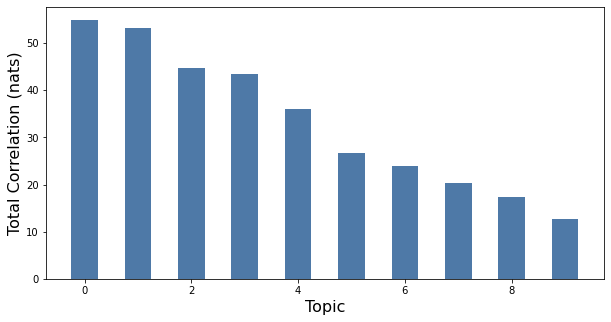

In [6]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.bar(range(topic_model.tcs.shape[0]), topic_model.tcs, color='#4e79a7', width=0.5)
plt.xlabel('Topic', fontsize=16)
plt.ylabel('Total Correlation (nats)', fontsize=16)

## Output

### Display all topics

In [7]:
topics = topic_model.get_topics()
for n,topic in enumerate(topics):
    topic_words,_,_ = zip(*topic)
    print('{}: '.format(n) + ', '.join(topic_words))

0: needs, mind, works, possible, person, giving, include, pay, within, working
1: four, due, group, return, five, despite, young, via, support, third
2: could, left, later, point, end, next, took, said, far, set
3: enough, side, least, makes, give, used, another, came, without, see
4: light, red, green, water, dark, dry, hot, extra, soft, cold
5: eye, show, ever, heart, space, create, friends, special, blue, fit
6: dish, sauce, recipe, delicious, ingredients, chicken, sweet, rice, recipes, cheese
7: location, local, visit, bar, street, city, hotel, located, places, park
8: government, war, rights, police, law, president, minister, legal, political, death
9: wearing, wear, dress, jeans, bag, jacket, fashion, shoes, shirt, worn


### Display Top Documents 
Given a topic, display the top documents for that topic.

In [11]:
topic_model.get_top_docs(topic=0, n_docs=10, sort_by='log_prob')

[('https://lifewithsonia.com/feed/', 0.0),
 ('http://mountainandseascotland.blogspot.com/feeds/posts/default?alt=rss',
  0.0),
 ('http://salmon-fishing-scotland.blogspot.com/feeds/posts/default?alt=rss',
  0.0),
 ('https://chokkablog.blogspot.com/feeds/posts/default?alt=rss', 0.0),
 ('https://www.recipesandreviews.co.uk/feeds/posts/default?alt=rss', 0.0),
 ('https://scottishboating.blogspot.com/feeds/posts/default', 0.0),
 ('https://isleofwhithorn.blogspot.com/feeds/posts/default?alt=rss', 0.0),
 ('http://www.afashionfix.co.uk/feeds/posts/default?alt=rss', 0.0),
 ('https://www.bernersmarketing.com/articles.xml', 0.0),
 ('http://feeds.feedburner.com/X-coutureGirl-x', 0.0)]

### Assignments of Documents to Topics

In [8]:
# Make a hard assignment of one topic per document
hard_labels = np.zeros(doc_word.shape[0])

for i in range(hard_labels.shape[0]):
    hard_labels[i] = np.argmax(topic_model.p_y_given_x[i])

# UMAP Plot

Loading BokehJS ...

<AxesSubplot:>

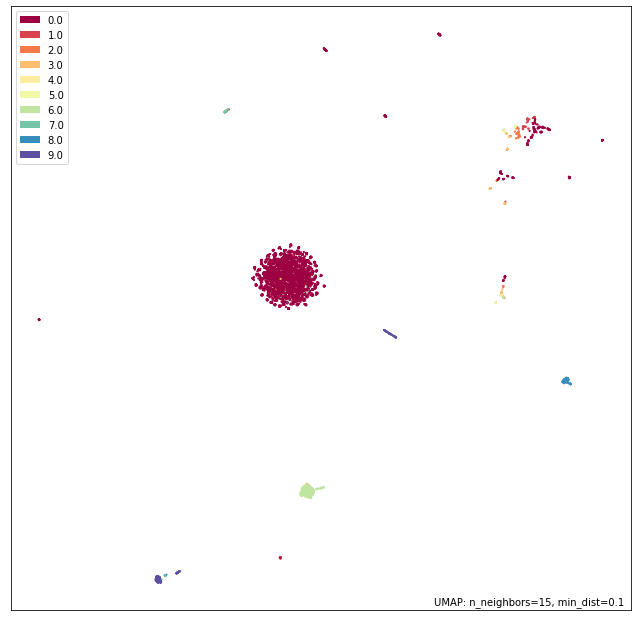

In [11]:
mapper = umap.UMAP().fit(topic_model.p_y_given_x)

hover_data = pd.DataFrame({
    'title': [v['title'] for v in feeds.values()],
    'description': [v['description'] for v in feeds.values()]
})

umap.plot.output_notebook()
p = umap.plot.interactive(mapper, labels=hard_labels, hover_data=hover_data, point_size=2)
umap.plot.show(p)

umap.plot.points(mapper, hard_labels)